In [1]:
import kagglehub

path = kagglehub.dataset_download("abdurraziq01/cloud-computing-performance-metrics")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cloud-computing-performance-metrics


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
sns.set(style="darkgrid")

df = pd.read_csv(f"{path}/vmCloud_data.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
print("Original columns:", df.columns.tolist())
print("Original shape:", df.shape)
df.head()

Original columns: ['vm_id', 'timestamp', 'cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions', 'execution_time', 'energy_efficiency', 'task_type', 'task_priority', 'task_status']
Original shape: (2000000, 12)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,c5215826-6237-4a33-9312-72c1df909881,2023-01-25 09:10:54,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,2023-01-26 04:46:34,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,2023-01-13 23:39:47,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed
3,e672e32f-c134-4fbc-992b-34eb63bef6bf,2023-02-09 11:45:49,54.488318,88.100960,NaN,195.639954,5876.0,16.456670,0.529511,compute,high,completed
4,f38b8b50-6926-4533-be4f-89ad11624071,2023-06-14 08:27:26,42.365480,NaN,NaN,359.451537,3361.0,55.307992,0.351907,NaN,medium,waiting


**DATA CLEANING**

In [ ]:
df.drop_duplicates(inplace=True)

df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)

In [ ]:
critical_cols = [
    'cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption',
    'num_executed_instructions', 'execution_time', 'energy_efficiency'
]
df.dropna(subset=critical_cols, inplace=True)

# Fill missing values in categorical columns
df['task_priority'] = df['task_priority'].fillna('unknown')
df['task_status'] = df['task_status'].fillna('unknown')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861102 entries, 0 to 1999999
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   vm_id                      774682 non-null  object        
 1   timestamp                  861102 non-null  datetime64[ns]
 2   cpu_usage                  861102 non-null  float64       
 3   memory_usage               861102 non-null  float64       
 4   network_traffic            861102 non-null  float64       
 5   power_consumption          861102 non-null  float64       
 6   num_executed_instructions  861102 non-null  float64       
 7   execution_time             861102 non-null  float64       
 8   energy_efficiency          861102 non-null  float64       
 9   task_type                  774852 non-null  object        
 10  task_priority              861102 non-null  object        
 11  task_status                861102 non-null  object      

**Feature Engineering**

In [5]:
label_encoder = LabelEncoder()
df['task_type_encoded'] = label_encoder.fit_transform(df['task_type'])

# Extract hour and day of the week from timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Drop unused or redundant columns
df.drop(columns=['vm_id', 'timestamp', 'task_type'], inplace=True)
print("Final columns after cleaning and encoding:", df.columns.tolist())


Final columns after cleaning and encoding: ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions', 'execution_time', 'energy_efficiency', 'task_priority', 'task_status', 'task_type_encoded', 'hour', 'day_of_week']


**Lag Features**

In [ ]:
df = df.sort_values(by='hour')

# Add lag features for CPU and memory usage
df['cpu_lag1'] = df['cpu_usage'].shift(1)
df['cpu_lag2'] = df['cpu_usage'].shift(2)
df['mem_lag1'] = df['memory_usage'].shift(1)
df['mem_lag2'] = df['memory_usage'].shift(2)
df['power'] = df['cpu_usage'] * 2.5 + df['memory_usage'] * 1.2

# Drop rows with NaNs
df.dropna(inplace=True)


In [7]:
df.to_csv("/kaggle/working/cleaned_vmCloud_data.csv", index=False)
print("Cleaned dataset saved as cleaned_vmCloud_data.csv")
df.head()

Cleaned dataset saved as cleaned_vmCloud_data.csv


,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_priority,task_status,task_type_encoded,hour,day_of_week,cpu_lag1,cpu_lag2,mem_lag1,mem_lag2,power
1699521,55.486209,68.169841,485.150941,347.433689,9872.0,10.140761,0.668453,unknown,waiting,3,0,2,24.996360,42.640129,82.681124,35.945715,220.519333
1883663,50.839843,69.741625,599.645947,355.979413,7201.0,70.708824,0.019766,high,unknown,2,0,6,55.486209,24.996360,68.169841,82.681124,210.789558
1296862,61.010460,92.479121,299.060601,291.478452,4161.0,80.705400,0.046042,high,unknown,2,0,5,50.839843,55.486209,69.741625,68.169841,263.501096
674160,23.411812,43.868242,716.950469,470.011688,892.0,79.815209,0.466644,high,completed,2,0,5,61.010460,50.839843,92.479121,69.741625,111.171421
995180,2.425301,88.056544,517.007302,415.365370,1030.0,1.319158,0.888394,low,waiting,2,0,6,23.411812,61.010460,43.868242,92.479121,111.731106


**Exploratory Data Analysis (EDA)**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


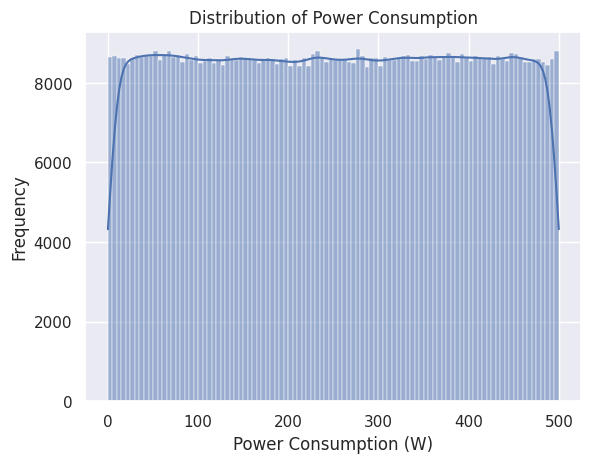

In [8]:
# Histogram of power consumption
sns.histplot(df['power_consumption'], bins=100, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption (W)')
plt.ylabel('Frequency')
plt.show()

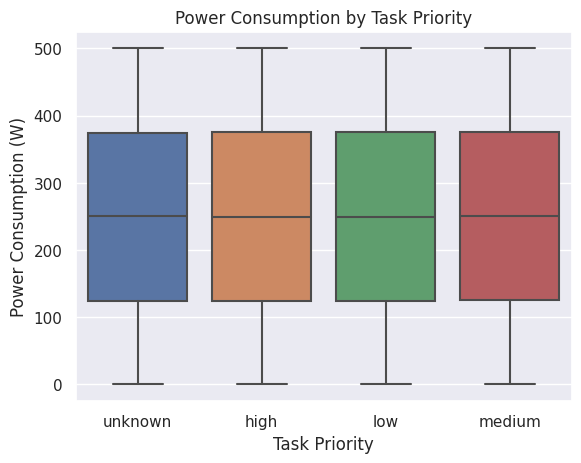

In [9]:
# Boxplot of power consumption by task priority
sns.boxplot(x='task_priority', y='power_consumption', data=df)
plt.title('Power Consumption by Task Priority')
plt.xlabel('Task Priority')
plt.ylabel('Power Consumption (W)')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

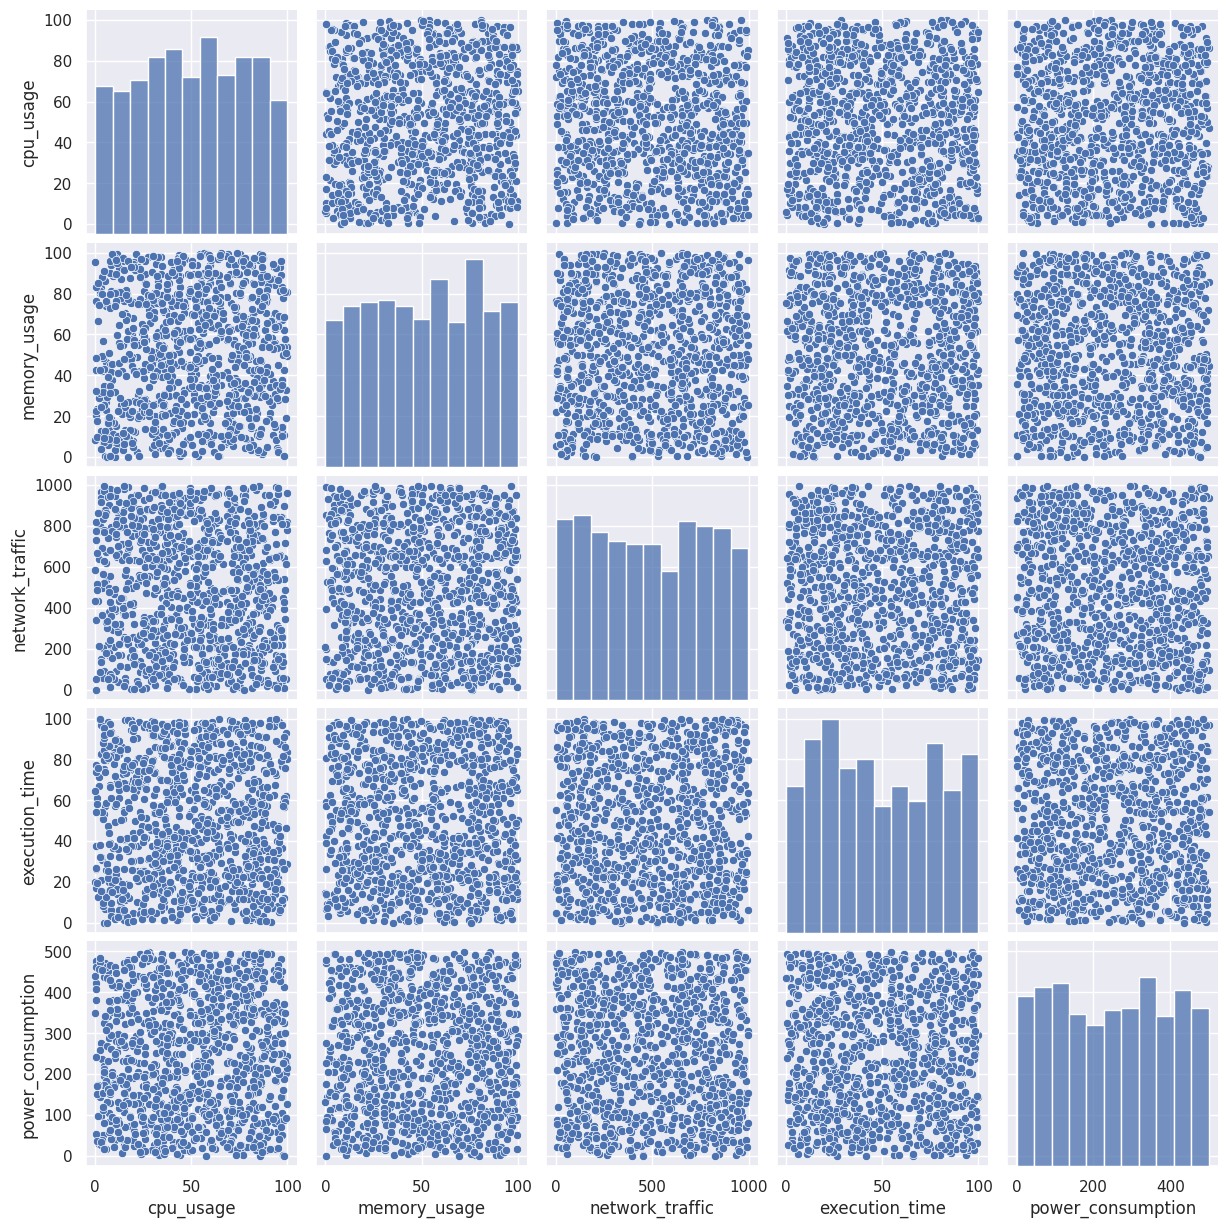

In [10]:
# Pairplot to inspect relationships among selected features
selected_features = ['cpu_usage', 'memory_usage', 'network_traffic', 'execution_time', 'power_consumption']
sns.pairplot(df.sample(1000), vars=selected_features)
plt.show()
